# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

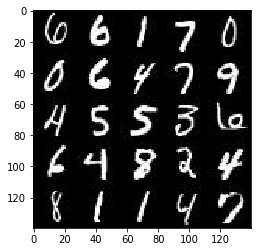

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

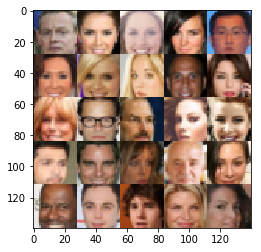

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # create the placeholders for the model
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    
    # return the placeholders
    return inputs_real, inputs_z, learning_rate

    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28x28xchannels
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        l1 = tf.maximum(alpha * l1, l1)
        
        # 14x14x64
        l2 = tf.layers.conv2d(l1, 128, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(alpha * l2, l2)

        # 7x7x128
        l3 = tf.layers.conv2d(l2, 256, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.maximum(alpha * l3, l3)
        
        # 4x4x256
        l4 = tf.reshape(l3, (-1, 4*4*256))
        logits = tf.layers.dense(l4, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param reuse: reuse variables
    :param alpha: leaky relu alpha value
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # start with a fully connected layer
        l1 = tf.layers.dense(z, 4*4*512)
        
        # reshape it for a convolutional stack
        l1 = tf.reshape(l1, (-1, 4, 4, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        
        # 4x4x512
        # formula for converting 4x4 input to 7x7 output discovered on forum
        l2 = tf.layers.conv2d_transpose(l1, 256, 4, strides=1, padding='valid')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        
        # 7x7x256
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)
        
        # 14x14x128
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(logits)
        # 28x28xchannels
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smoothing = 0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_model_real) * smoothing))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    # Optimize
#     d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
#     g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
from matplotlib import pyplot as plt

def plot_losses(d_loss, g_loss):
    """
    Plot the discriminator and generator losses on the same graph
    :param d_loss: list of loss values for the discriminator
    :param g_loss: list of loss values for the generator
    """
    fig, ax = plt.subplots()
    plt.plot(d_loss, label='Discriminator', alpha=0.5)
    plt.plot(g_loss, label='Generator', alpha=0.5)
    plt.title("Training Loss")
    plt.legend()

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    real_inputs, z_inputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_no = 0

    d_losses = []
    g_losses = []
    
#     update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#     with tf.control_dependencies(update_ops):
#         # Ensures that we execute the update_ops before performing the train_step
#         train_step = tf.train.GradientDescentOptimizer(0.01).minimize(g_loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_no += 1
                
                # scale batch images to [-1.0, 1.0]
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr: learning_rate})
                
                # show loss every 10 steps
                if batch_no % 10 == 0: 

                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({z_inputs: batch_z, lr: learning_rate})
                    d_losses.append(train_loss_d)
                    g_losses.append(train_loss_g)
                    print("Epoch {}/{}: batch {}: discriminator loss: {:.4f} generator loss: {:.4f}".format(
                         epoch_i+1, epoch_count, batch_no, train_loss_d, train_loss_g))
                
                # show generator output every 100
                if batch_no % 100 == 0: 
                    show_generator_output(sess, 25, z_inputs, data_shape[-1], data_image_mode)

        # show the final output if the batches don't mod out evenly
        show_generator_output(sess, 25, z_inputs, data_shape[-1], data_image_mode)
        return d_losses, g_losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2: batch 10: discriminator loss: 4.6658 generator loss: 0.0188
Epoch 1/2: batch 20: discriminator loss: 1.1602 generator loss: 1.1299
Epoch 1/2: batch 30: discriminator loss: 3.0904 generator loss: 9.6995
Epoch 1/2: batch 40: discriminator loss: 0.8662 generator loss: 1.0335
Epoch 1/2: batch 50: discriminator loss: 0.8962 generator loss: 1.1044
Epoch 1/2: batch 60: discriminator loss: 0.6405 generator loss: 2.1946
Epoch 1/2: batch 70: discriminator loss: 2.0216 generator loss: 3.9516
Epoch 1/2: batch 80: discriminator loss: 1.5958 generator loss: 2.6696
Epoch 1/2: batch 90: discriminator loss: 1.3012 generator loss: 2.6460
Epoch 1/2: batch 100: discriminator loss: 1.2250 generator loss: 1.6449


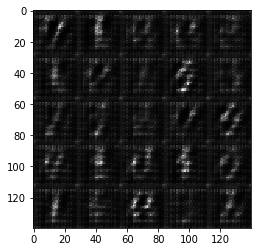

Epoch 1/2: batch 110: discriminator loss: 1.5738 generator loss: 2.0996
Epoch 1/2: batch 120: discriminator loss: 1.2867 generator loss: 1.5585
Epoch 1/2: batch 130: discriminator loss: 1.5344 generator loss: 1.2365
Epoch 1/2: batch 140: discriminator loss: 1.4034 generator loss: 1.4717
Epoch 1/2: batch 150: discriminator loss: 1.3822 generator loss: 1.4169
Epoch 1/2: batch 160: discriminator loss: 1.5519 generator loss: 1.8427
Epoch 1/2: batch 170: discriminator loss: 1.2985 generator loss: 1.2939
Epoch 1/2: batch 180: discriminator loss: 1.3877 generator loss: 1.3098
Epoch 1/2: batch 190: discriminator loss: 1.3767 generator loss: 1.0012
Epoch 1/2: batch 200: discriminator loss: 1.4044 generator loss: 1.2231


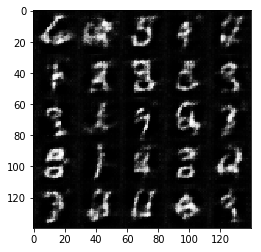

Epoch 1/2: batch 210: discriminator loss: 1.4721 generator loss: 1.4638
Epoch 1/2: batch 220: discriminator loss: 1.3204 generator loss: 1.3706
Epoch 1/2: batch 230: discriminator loss: 1.4187 generator loss: 1.4377
Epoch 1/2: batch 240: discriminator loss: 1.3322 generator loss: 1.3359
Epoch 1/2: batch 250: discriminator loss: 1.3249 generator loss: 1.1828
Epoch 1/2: batch 260: discriminator loss: 1.4382 generator loss: 1.2258
Epoch 1/2: batch 270: discriminator loss: 1.2980 generator loss: 1.0354
Epoch 1/2: batch 280: discriminator loss: 1.3557 generator loss: 1.1901
Epoch 1/2: batch 290: discriminator loss: 1.4132 generator loss: 1.2579
Epoch 1/2: batch 300: discriminator loss: 1.3821 generator loss: 1.3606


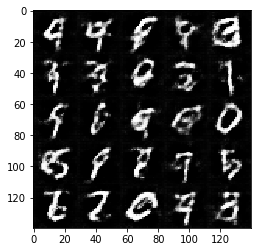

Epoch 1/2: batch 310: discriminator loss: 1.4625 generator loss: 1.4804
Epoch 1/2: batch 320: discriminator loss: 1.3675 generator loss: 1.3608
Epoch 1/2: batch 330: discriminator loss: 1.3339 generator loss: 1.3541
Epoch 1/2: batch 340: discriminator loss: 1.4059 generator loss: 1.3312
Epoch 1/2: batch 350: discriminator loss: 1.4398 generator loss: 1.4334
Epoch 1/2: batch 360: discriminator loss: 1.3756 generator loss: 1.3564
Epoch 1/2: batch 370: discriminator loss: 1.3475 generator loss: 1.2577
Epoch 1/2: batch 380: discriminator loss: 1.4928 generator loss: 1.6475
Epoch 1/2: batch 390: discriminator loss: 1.3984 generator loss: 1.4613
Epoch 1/2: batch 400: discriminator loss: 1.3143 generator loss: 1.2941


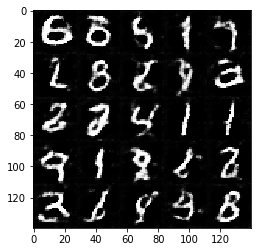

Epoch 1/2: batch 410: discriminator loss: 1.2663 generator loss: 1.0715
Epoch 1/2: batch 420: discriminator loss: 1.4273 generator loss: 1.3327
Epoch 1/2: batch 430: discriminator loss: 1.4679 generator loss: 1.5174
Epoch 1/2: batch 440: discriminator loss: 1.2848 generator loss: 1.1583
Epoch 1/2: batch 450: discriminator loss: 1.4479 generator loss: 1.5629
Epoch 1/2: batch 460: discriminator loss: 1.2864 generator loss: 1.1779
Epoch 2/2: batch 470: discriminator loss: 1.4321 generator loss: 1.6581
Epoch 2/2: batch 480: discriminator loss: 1.3220 generator loss: 1.1954
Epoch 2/2: batch 490: discriminator loss: 1.2903 generator loss: 1.4057
Epoch 2/2: batch 500: discriminator loss: 1.2893 generator loss: 1.1335


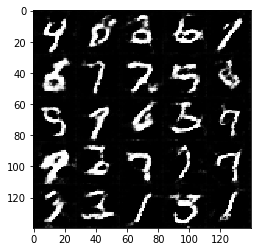

Epoch 2/2: batch 510: discriminator loss: 1.3955 generator loss: 1.4014
Epoch 2/2: batch 520: discriminator loss: 1.2744 generator loss: 1.2480
Epoch 2/2: batch 530: discriminator loss: 1.3401 generator loss: 1.3984
Epoch 2/2: batch 540: discriminator loss: 1.3546 generator loss: 1.2704
Epoch 2/2: batch 550: discriminator loss: 1.2243 generator loss: 1.3518
Epoch 2/2: batch 560: discriminator loss: 1.2897 generator loss: 1.0881
Epoch 2/2: batch 570: discriminator loss: 1.2621 generator loss: 1.0423
Epoch 2/2: batch 580: discriminator loss: 1.3162 generator loss: 1.4520
Epoch 2/2: batch 590: discriminator loss: 1.2184 generator loss: 1.1106
Epoch 2/2: batch 600: discriminator loss: 1.4843 generator loss: 1.6520


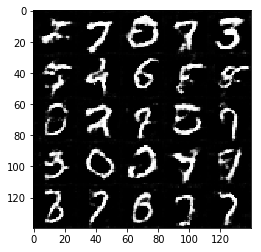

Epoch 2/2: batch 610: discriminator loss: 1.2208 generator loss: 0.9881
Epoch 2/2: batch 620: discriminator loss: 2.9531 generator loss: 3.2664
Epoch 2/2: batch 630: discriminator loss: 1.3143 generator loss: 0.9671
Epoch 2/2: batch 640: discriminator loss: 1.2818 generator loss: 1.1503
Epoch 2/2: batch 650: discriminator loss: 1.2535 generator loss: 1.1286
Epoch 2/2: batch 660: discriminator loss: 1.2544 generator loss: 0.7925
Epoch 2/2: batch 670: discriminator loss: 1.5624 generator loss: 2.0002
Epoch 2/2: batch 680: discriminator loss: 1.2277 generator loss: 0.8230
Epoch 2/2: batch 690: discriminator loss: 1.7386 generator loss: 2.0429
Epoch 2/2: batch 700: discriminator loss: 1.2915 generator loss: 1.3025


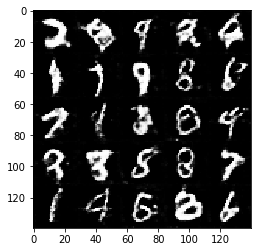

Epoch 2/2: batch 710: discriminator loss: 1.5287 generator loss: 1.6431
Epoch 2/2: batch 720: discriminator loss: 1.1916 generator loss: 1.2519
Epoch 2/2: batch 730: discriminator loss: 1.5596 generator loss: 1.8297
Epoch 2/2: batch 740: discriminator loss: 1.2976 generator loss: 1.5143
Epoch 2/2: batch 750: discriminator loss: 1.4043 generator loss: 1.4962
Epoch 2/2: batch 760: discriminator loss: 1.3043 generator loss: 1.6752
Epoch 2/2: batch 770: discriminator loss: 1.4014 generator loss: 1.5765
Epoch 2/2: batch 780: discriminator loss: 1.1533 generator loss: 1.3625
Epoch 2/2: batch 790: discriminator loss: 1.4379 generator loss: 1.5026
Epoch 2/2: batch 800: discriminator loss: 1.2434 generator loss: 1.3579


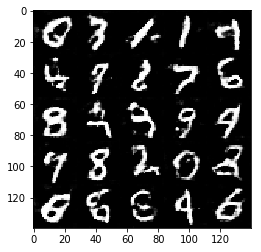

Epoch 2/2: batch 810: discriminator loss: 1.1113 generator loss: 0.9870
Epoch 2/2: batch 820: discriminator loss: 1.2073 generator loss: 1.2793
Epoch 2/2: batch 830: discriminator loss: 1.3453 generator loss: 1.5103
Epoch 2/2: batch 840: discriminator loss: 1.2030 generator loss: 1.5211
Epoch 2/2: batch 850: discriminator loss: 1.2840 generator loss: 1.4915
Epoch 2/2: batch 860: discriminator loss: 1.6050 generator loss: 1.9595
Epoch 2/2: batch 870: discriminator loss: 1.1167 generator loss: 1.0123
Epoch 2/2: batch 880: discriminator loss: 1.3813 generator loss: 2.0821
Epoch 2/2: batch 890: discriminator loss: 1.2137 generator loss: 1.2752
Epoch 2/2: batch 900: discriminator loss: 1.4380 generator loss: 1.9765


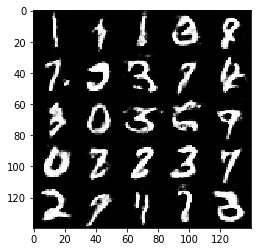

Epoch 2/2: batch 910: discriminator loss: 1.1889 generator loss: 1.2759
Epoch 2/2: batch 920: discriminator loss: 1.0969 generator loss: 1.0674
Epoch 2/2: batch 930: discriminator loss: 1.1883 generator loss: 1.1154


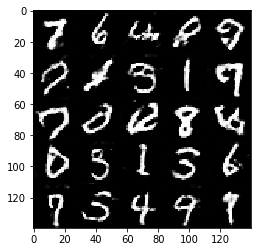

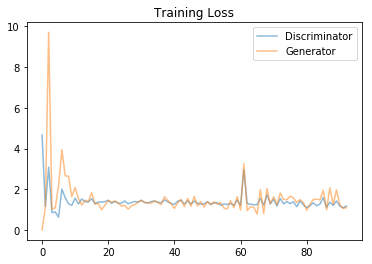

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.2

d_losses = []
g_losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

    plot_losses(d_losses, g_losses)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2: batch 10: discriminator loss: 1.4819 generator loss: 12.7049
Epoch 1/2: batch 20: discriminator loss: 0.6701 generator loss: 10.6405
Epoch 1/2: batch 30: discriminator loss: 2.6786 generator loss: 13.3328
Epoch 1/2: batch 40: discriminator loss: 1.2862 generator loss: 8.0544
Epoch 1/2: batch 50: discriminator loss: 0.6499 generator loss: 4.9863
Epoch 1/2: batch 60: discriminator loss: 1.6392 generator loss: 8.7268
Epoch 1/2: batch 70: discriminator loss: 1.2311 generator loss: 0.9865
Epoch 1/2: batch 80: discriminator loss: 1.2581 generator loss: 1.2514
Epoch 1/2: batch 90: discriminator loss: 1.1073 generator loss: 0.9826
Epoch 1/2: batch 100: discriminator loss: 1.1759 generator loss: 1.2616


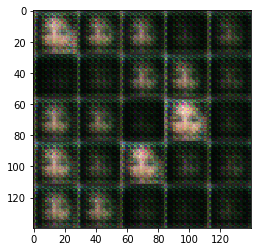

Epoch 1/2: batch 110: discriminator loss: 0.9120 generator loss: 1.7562
Epoch 1/2: batch 120: discriminator loss: 1.5652 generator loss: 0.4825
Epoch 1/2: batch 130: discriminator loss: 1.1740 generator loss: 1.1481
Epoch 1/2: batch 140: discriminator loss: 1.2250 generator loss: 1.1829
Epoch 1/2: batch 150: discriminator loss: 0.9785 generator loss: 1.2456
Epoch 1/2: batch 160: discriminator loss: 1.3136 generator loss: 1.4664
Epoch 1/2: batch 170: discriminator loss: 1.4461 generator loss: 0.9230
Epoch 1/2: batch 180: discriminator loss: 1.4082 generator loss: 1.3262
Epoch 1/2: batch 190: discriminator loss: 1.2272 generator loss: 1.4603
Epoch 1/2: batch 200: discriminator loss: 1.3754 generator loss: 1.3510


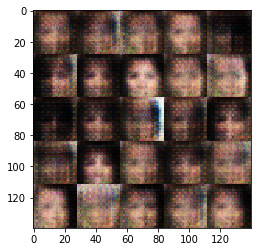

Epoch 1/2: batch 210: discriminator loss: 1.4576 generator loss: 0.5365
Epoch 1/2: batch 220: discriminator loss: 1.3512 generator loss: 0.6387
Epoch 1/2: batch 230: discriminator loss: 1.2182 generator loss: 1.2805
Epoch 1/2: batch 240: discriminator loss: 1.3596 generator loss: 0.6141
Epoch 1/2: batch 250: discriminator loss: 1.2098 generator loss: 1.2461
Epoch 1/2: batch 260: discriminator loss: 1.2792 generator loss: 0.8221
Epoch 1/2: batch 270: discriminator loss: 1.7610 generator loss: 0.3322
Epoch 1/2: batch 280: discriminator loss: 1.4060 generator loss: 1.6339
Epoch 1/2: batch 290: discriminator loss: 1.1154 generator loss: 1.2669
Epoch 1/2: batch 300: discriminator loss: 1.9497 generator loss: 2.6086


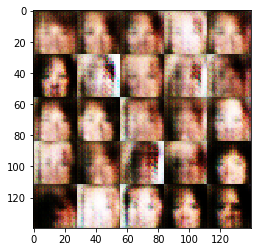

Epoch 1/2: batch 310: discriminator loss: 1.3211 generator loss: 0.6368
Epoch 1/2: batch 320: discriminator loss: 1.1855 generator loss: 0.8739
Epoch 1/2: batch 330: discriminator loss: 1.4013 generator loss: 0.7493
Epoch 1/2: batch 340: discriminator loss: 1.2375 generator loss: 1.3092
Epoch 1/2: batch 350: discriminator loss: 1.2385 generator loss: 0.7161
Epoch 1/2: batch 360: discriminator loss: 0.9105 generator loss: 1.1698
Epoch 1/2: batch 370: discriminator loss: 1.1779 generator loss: 0.8114
Epoch 1/2: batch 380: discriminator loss: 1.0573 generator loss: 0.8394
Epoch 1/2: batch 390: discriminator loss: 0.7541 generator loss: 2.6230
Epoch 1/2: batch 400: discriminator loss: 1.2451 generator loss: 0.6307


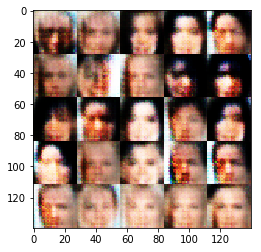

Epoch 1/2: batch 410: discriminator loss: 1.0434 generator loss: 1.0142
Epoch 1/2: batch 420: discriminator loss: 1.4803 generator loss: 0.4807
Epoch 1/2: batch 430: discriminator loss: 1.0641 generator loss: 1.4069
Epoch 1/2: batch 440: discriminator loss: 1.8575 generator loss: 0.4352
Epoch 1/2: batch 450: discriminator loss: 1.1762 generator loss: 0.9623
Epoch 1/2: batch 460: discriminator loss: 1.4682 generator loss: 0.4567
Epoch 1/2: batch 470: discriminator loss: 1.4378 generator loss: 0.4435
Epoch 1/2: batch 480: discriminator loss: 1.2162 generator loss: 0.9503
Epoch 1/2: batch 490: discriminator loss: 1.0593 generator loss: 0.9630
Epoch 1/2: batch 500: discriminator loss: 1.3029 generator loss: 0.9496


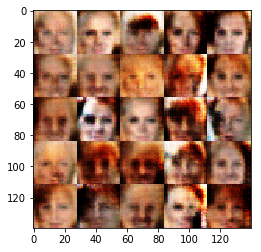

Epoch 1/2: batch 510: discriminator loss: 1.1007 generator loss: 0.8165
Epoch 1/2: batch 520: discriminator loss: 1.3265 generator loss: 1.6227
Epoch 1/2: batch 530: discriminator loss: 1.0724 generator loss: 0.7492
Epoch 1/2: batch 540: discriminator loss: 1.3186 generator loss: 1.0770
Epoch 1/2: batch 550: discriminator loss: 1.0083 generator loss: 1.0766
Epoch 1/2: batch 560: discriminator loss: 1.2787 generator loss: 0.7287
Epoch 1/2: batch 570: discriminator loss: 1.1350 generator loss: 2.3390
Epoch 1/2: batch 580: discriminator loss: 1.1076 generator loss: 0.9880
Epoch 1/2: batch 590: discriminator loss: 1.0477 generator loss: 1.3341
Epoch 1/2: batch 600: discriminator loss: 0.8631 generator loss: 1.2902


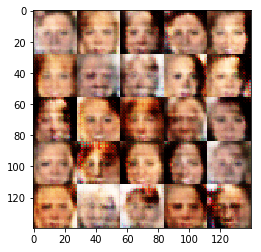

Epoch 1/2: batch 610: discriminator loss: 1.4617 generator loss: 0.7932
Epoch 1/2: batch 620: discriminator loss: 1.4737 generator loss: 0.6750
Epoch 1/2: batch 630: discriminator loss: 1.3238 generator loss: 1.5168
Epoch 1/2: batch 640: discriminator loss: 1.2044 generator loss: 1.1876
Epoch 1/2: batch 650: discriminator loss: 1.2851 generator loss: 0.6031
Epoch 1/2: batch 660: discriminator loss: 1.9301 generator loss: 0.2547
Epoch 1/2: batch 670: discriminator loss: 1.1256 generator loss: 0.8475
Epoch 1/2: batch 680: discriminator loss: 1.3037 generator loss: 0.6357
Epoch 1/2: batch 690: discriminator loss: 1.2674 generator loss: 0.9566
Epoch 1/2: batch 700: discriminator loss: 1.3650 generator loss: 0.8095


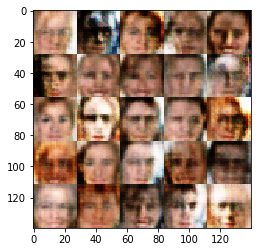

Epoch 1/2: batch 710: discriminator loss: 1.2233 generator loss: 0.9332
Epoch 1/2: batch 720: discriminator loss: 0.7184 generator loss: 1.6948
Epoch 1/2: batch 730: discriminator loss: 1.4860 generator loss: 0.7967
Epoch 1/2: batch 740: discriminator loss: 1.8167 generator loss: 0.2817
Epoch 1/2: batch 750: discriminator loss: 1.4440 generator loss: 0.4687
Epoch 1/2: batch 760: discriminator loss: 1.2686 generator loss: 0.9697
Epoch 1/2: batch 770: discriminator loss: 1.2961 generator loss: 0.8070
Epoch 1/2: batch 780: discriminator loss: 1.2614 generator loss: 0.9348
Epoch 1/2: batch 790: discriminator loss: 1.2368 generator loss: 0.7566
Epoch 1/2: batch 800: discriminator loss: 1.2405 generator loss: 1.1429


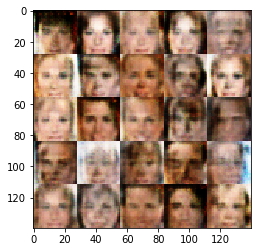

Epoch 1/2: batch 810: discriminator loss: 1.3368 generator loss: 0.6687
Epoch 1/2: batch 820: discriminator loss: 1.2127 generator loss: 0.9714
Epoch 1/2: batch 830: discriminator loss: 1.3781 generator loss: 0.8867
Epoch 1/2: batch 840: discriminator loss: 1.1406 generator loss: 1.1175
Epoch 1/2: batch 850: discriminator loss: 1.1127 generator loss: 1.5130
Epoch 1/2: batch 860: discriminator loss: 1.4661 generator loss: 1.5665
Epoch 1/2: batch 870: discriminator loss: 1.4209 generator loss: 1.1960
Epoch 1/2: batch 880: discriminator loss: 1.2769 generator loss: 0.9761
Epoch 1/2: batch 890: discriminator loss: 1.1542 generator loss: 1.3743
Epoch 1/2: batch 900: discriminator loss: 1.1591 generator loss: 0.8200


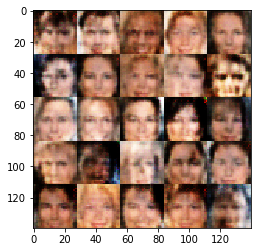

Epoch 1/2: batch 910: discriminator loss: 1.3905 generator loss: 1.5897
Epoch 1/2: batch 920: discriminator loss: 1.3065 generator loss: 0.5414
Epoch 1/2: batch 930: discriminator loss: 1.1119 generator loss: 1.1930
Epoch 1/2: batch 940: discriminator loss: 1.0563 generator loss: 0.8765
Epoch 1/2: batch 950: discriminator loss: 0.5612 generator loss: 2.1116
Epoch 1/2: batch 960: discriminator loss: 1.4933 generator loss: 0.6820
Epoch 1/2: batch 970: discriminator loss: 1.3823 generator loss: 0.5438
Epoch 1/2: batch 980: discriminator loss: 1.2757 generator loss: 1.0504
Epoch 1/2: batch 990: discriminator loss: 0.9428 generator loss: 1.5706
Epoch 1/2: batch 1000: discriminator loss: 1.2243 generator loss: 1.0021


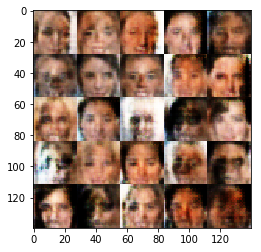

Epoch 1/2: batch 1010: discriminator loss: 1.2270 generator loss: 0.7217
Epoch 1/2: batch 1020: discriminator loss: 1.1695 generator loss: 1.0324
Epoch 1/2: batch 1030: discriminator loss: 1.0163 generator loss: 1.1468
Epoch 1/2: batch 1040: discriminator loss: 1.4235 generator loss: 1.0319
Epoch 1/2: batch 1050: discriminator loss: 1.5430 generator loss: 0.4258
Epoch 1/2: batch 1060: discriminator loss: 1.1117 generator loss: 1.2555
Epoch 1/2: batch 1070: discriminator loss: 1.3420 generator loss: 0.8400
Epoch 1/2: batch 1080: discriminator loss: 1.2820 generator loss: 0.8678
Epoch 1/2: batch 1090: discriminator loss: 1.1864 generator loss: 0.9243
Epoch 1/2: batch 1100: discriminator loss: 1.0328 generator loss: 1.1697


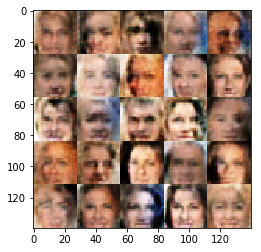

Epoch 1/2: batch 1110: discriminator loss: 1.0984 generator loss: 0.8654
Epoch 1/2: batch 1120: discriminator loss: 1.7258 generator loss: 1.6025
Epoch 1/2: batch 1130: discriminator loss: 1.3417 generator loss: 0.5920
Epoch 1/2: batch 1140: discriminator loss: 0.8102 generator loss: 2.0675
Epoch 1/2: batch 1150: discriminator loss: 1.4320 generator loss: 0.8975
Epoch 1/2: batch 1160: discriminator loss: 1.3908 generator loss: 0.8777
Epoch 1/2: batch 1170: discriminator loss: 1.3918 generator loss: 0.7498
Epoch 1/2: batch 1180: discriminator loss: 1.3000 generator loss: 0.8825
Epoch 1/2: batch 1190: discriminator loss: 1.3589 generator loss: 0.7560
Epoch 1/2: batch 1200: discriminator loss: 1.0042 generator loss: 1.1171


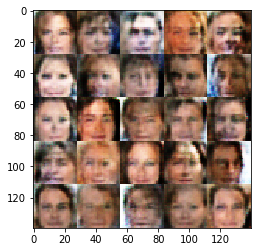

Epoch 1/2: batch 1210: discriminator loss: 1.3758 generator loss: 0.6721
Epoch 1/2: batch 1220: discriminator loss: 1.2139 generator loss: 0.6946
Epoch 1/2: batch 1230: discriminator loss: 1.3916 generator loss: 0.7712
Epoch 1/2: batch 1240: discriminator loss: 1.3136 generator loss: 0.7817
Epoch 1/2: batch 1250: discriminator loss: 1.2037 generator loss: 0.7544
Epoch 1/2: batch 1260: discriminator loss: 1.3507 generator loss: 0.6041
Epoch 1/2: batch 1270: discriminator loss: 1.3431 generator loss: 0.5998
Epoch 1/2: batch 1280: discriminator loss: 1.2038 generator loss: 0.7220
Epoch 1/2: batch 1290: discriminator loss: 1.3293 generator loss: 0.8793
Epoch 1/2: batch 1300: discriminator loss: 1.3423 generator loss: 0.8357


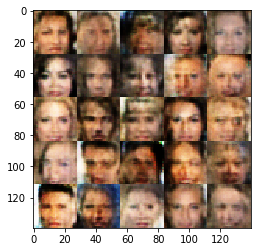

Epoch 1/2: batch 1310: discriminator loss: 1.1138 generator loss: 0.9003
Epoch 1/2: batch 1320: discriminator loss: 1.5822 generator loss: 0.4175
Epoch 1/2: batch 1330: discriminator loss: 1.3879 generator loss: 1.2330
Epoch 1/2: batch 1340: discriminator loss: 1.2557 generator loss: 1.0907
Epoch 1/2: batch 1350: discriminator loss: 1.2986 generator loss: 0.7633
Epoch 1/2: batch 1360: discriminator loss: 1.3287 generator loss: 0.8577
Epoch 1/2: batch 1370: discriminator loss: 1.3181 generator loss: 1.0880
Epoch 1/2: batch 1380: discriminator loss: 1.3623 generator loss: 0.8158
Epoch 1/2: batch 1390: discriminator loss: 1.2039 generator loss: 0.7582
Epoch 1/2: batch 1400: discriminator loss: 1.9148 generator loss: 2.6778


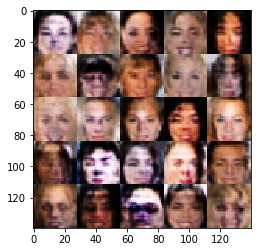

Epoch 1/2: batch 1410: discriminator loss: 1.3597 generator loss: 1.0811
Epoch 1/2: batch 1420: discriminator loss: 1.3251 generator loss: 1.1936
Epoch 1/2: batch 1430: discriminator loss: 1.3913 generator loss: 0.5364
Epoch 1/2: batch 1440: discriminator loss: 1.3244 generator loss: 0.8876
Epoch 1/2: batch 1450: discriminator loss: 1.2841 generator loss: 1.0383
Epoch 1/2: batch 1460: discriminator loss: 1.2953 generator loss: 1.0086
Epoch 1/2: batch 1470: discriminator loss: 1.3300 generator loss: 0.9755
Epoch 1/2: batch 1480: discriminator loss: 1.3405 generator loss: 2.0880
Epoch 1/2: batch 1490: discriminator loss: 1.3264 generator loss: 0.7048
Epoch 1/2: batch 1500: discriminator loss: 1.3082 generator loss: 0.7274


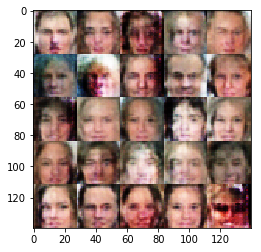

Epoch 1/2: batch 1510: discriminator loss: 1.2001 generator loss: 1.1125
Epoch 1/2: batch 1520: discriminator loss: 1.1548 generator loss: 0.8421
Epoch 1/2: batch 1530: discriminator loss: 1.4083 generator loss: 0.8979
Epoch 1/2: batch 1540: discriminator loss: 1.2827 generator loss: 1.0051
Epoch 1/2: batch 1550: discriminator loss: 1.2933 generator loss: 1.0969
Epoch 1/2: batch 1560: discriminator loss: 1.4416 generator loss: 0.5089
Epoch 1/2: batch 1570: discriminator loss: 1.2791 generator loss: 0.7716
Epoch 1/2: batch 1580: discriminator loss: 1.7037 generator loss: 1.6687
Epoch 2/2: batch 1590: discriminator loss: 1.2198 generator loss: 0.9418
Epoch 2/2: batch 1600: discriminator loss: 1.0451 generator loss: 1.1960


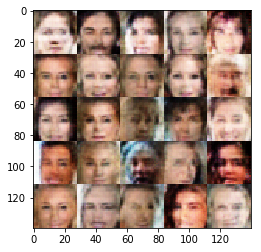

Epoch 2/2: batch 1610: discriminator loss: 0.9999 generator loss: 0.9157
Epoch 2/2: batch 1620: discriminator loss: 1.2572 generator loss: 1.0046
Epoch 2/2: batch 1630: discriminator loss: 1.4359 generator loss: 0.5004
Epoch 2/2: batch 1640: discriminator loss: 1.2498 generator loss: 0.8572
Epoch 2/2: batch 1650: discriminator loss: 1.3803 generator loss: 0.5403
Epoch 2/2: batch 1660: discriminator loss: 1.3432 generator loss: 0.6445
Epoch 2/2: batch 1670: discriminator loss: 1.4861 generator loss: 0.4666
Epoch 2/2: batch 1680: discriminator loss: 1.5069 generator loss: 0.4913
Epoch 2/2: batch 1690: discriminator loss: 1.2952 generator loss: 0.8013
Epoch 2/2: batch 1700: discriminator loss: 1.3140 generator loss: 0.6513


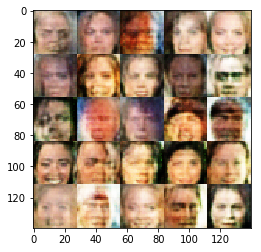

Epoch 2/2: batch 1710: discriminator loss: 1.3109 generator loss: 0.6526
Epoch 2/2: batch 1720: discriminator loss: 1.1608 generator loss: 0.7733
Epoch 2/2: batch 1730: discriminator loss: 1.4028 generator loss: 0.6821
Epoch 2/2: batch 1740: discriminator loss: 1.2703 generator loss: 0.8187
Epoch 2/2: batch 1750: discriminator loss: 1.1885 generator loss: 0.8511
Epoch 2/2: batch 1760: discriminator loss: 1.3037 generator loss: 0.8598
Epoch 2/2: batch 1770: discriminator loss: 1.3899 generator loss: 0.9436
Epoch 2/2: batch 1780: discriminator loss: 1.2686 generator loss: 1.6863
Epoch 2/2: batch 1790: discriminator loss: 1.4342 generator loss: 0.5824
Epoch 2/2: batch 1800: discriminator loss: 1.3742 generator loss: 0.6640


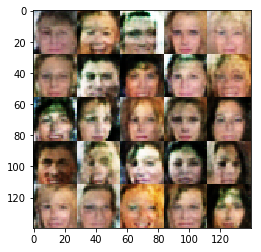

Epoch 2/2: batch 1810: discriminator loss: 1.3362 generator loss: 0.7939
Epoch 2/2: batch 1820: discriminator loss: 1.2580 generator loss: 0.8169
Epoch 2/2: batch 1830: discriminator loss: 1.4123 generator loss: 0.5183
Epoch 2/2: batch 1840: discriminator loss: 1.3141 generator loss: 0.7185
Epoch 2/2: batch 1850: discriminator loss: 1.3233 generator loss: 0.8780
Epoch 2/2: batch 1860: discriminator loss: 1.3197 generator loss: 0.9139
Epoch 2/2: batch 1870: discriminator loss: 1.3792 generator loss: 0.5136
Epoch 2/2: batch 1880: discriminator loss: 1.2560 generator loss: 1.0574
Epoch 2/2: batch 1890: discriminator loss: 1.2530 generator loss: 0.8203
Epoch 2/2: batch 1900: discriminator loss: 1.4396 generator loss: 0.5488


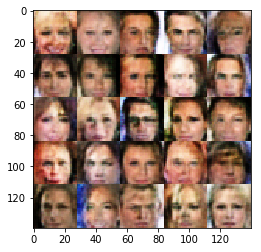

Epoch 2/2: batch 1910: discriminator loss: 1.3491 generator loss: 0.5745
Epoch 2/2: batch 1920: discriminator loss: 1.3036 generator loss: 1.0475
Epoch 2/2: batch 1930: discriminator loss: 1.3373 generator loss: 0.9109
Epoch 2/2: batch 1940: discriminator loss: 1.4527 generator loss: 0.4889
Epoch 2/2: batch 1950: discriminator loss: 1.4184 generator loss: 1.1695
Epoch 2/2: batch 1960: discriminator loss: 1.1647 generator loss: 1.4237
Epoch 2/2: batch 1970: discriminator loss: 1.2976 generator loss: 0.7880
Epoch 2/2: batch 1980: discriminator loss: 1.2636 generator loss: 0.9305
Epoch 2/2: batch 1990: discriminator loss: 1.2625 generator loss: 0.7712
Epoch 2/2: batch 2000: discriminator loss: 1.2322 generator loss: 0.8666


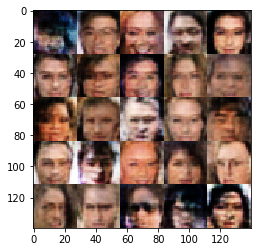

Epoch 2/2: batch 2010: discriminator loss: 1.3112 generator loss: 0.6847
Epoch 2/2: batch 2020: discriminator loss: 1.5677 generator loss: 1.3454
Epoch 2/2: batch 2030: discriminator loss: 1.2815 generator loss: 0.7990
Epoch 2/2: batch 2040: discriminator loss: 1.2810 generator loss: 0.6591
Epoch 2/2: batch 2050: discriminator loss: 1.3229 generator loss: 0.6161
Epoch 2/2: batch 2060: discriminator loss: 1.4417 generator loss: 0.6017
Epoch 2/2: batch 2070: discriminator loss: 1.3771 generator loss: 0.6080
Epoch 2/2: batch 2080: discriminator loss: 1.7224 generator loss: 0.3411
Epoch 2/2: batch 2090: discriminator loss: 1.2409 generator loss: 0.9469
Epoch 2/2: batch 2100: discriminator loss: 1.2237 generator loss: 0.8255


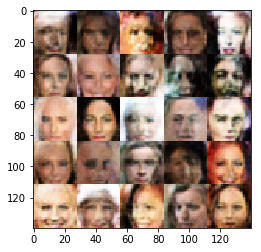

Epoch 2/2: batch 2110: discriminator loss: 1.2537 generator loss: 0.7408
Epoch 2/2: batch 2120: discriminator loss: 1.3825 generator loss: 1.2023
Epoch 2/2: batch 2130: discriminator loss: 1.2413 generator loss: 0.9688
Epoch 2/2: batch 2140: discriminator loss: 1.2813 generator loss: 0.7101
Epoch 2/2: batch 2150: discriminator loss: 1.3133 generator loss: 0.6449
Epoch 2/2: batch 2160: discriminator loss: 1.1491 generator loss: 1.1573
Epoch 2/2: batch 2170: discriminator loss: 1.4282 generator loss: 0.8140
Epoch 2/2: batch 2180: discriminator loss: 1.2519 generator loss: 0.8572
Epoch 2/2: batch 2190: discriminator loss: 1.3129 generator loss: 0.8455
Epoch 2/2: batch 2200: discriminator loss: 1.2542 generator loss: 0.7030


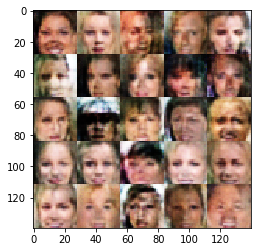

Epoch 2/2: batch 2210: discriminator loss: 1.2462 generator loss: 1.0052
Epoch 2/2: batch 2220: discriminator loss: 1.2448 generator loss: 0.7723
Epoch 2/2: batch 2230: discriminator loss: 1.3075 generator loss: 0.8767
Epoch 2/2: batch 2240: discriminator loss: 1.2143 generator loss: 0.8642
Epoch 2/2: batch 2250: discriminator loss: 1.5118 generator loss: 0.5047
Epoch 2/2: batch 2260: discriminator loss: 1.2791 generator loss: 0.8567
Epoch 2/2: batch 2270: discriminator loss: 1.2654 generator loss: 0.9380
Epoch 2/2: batch 2280: discriminator loss: 1.4816 generator loss: 1.3730
Epoch 2/2: batch 2290: discriminator loss: 1.2950 generator loss: 0.8101
Epoch 2/2: batch 2300: discriminator loss: 1.2502 generator loss: 0.7498


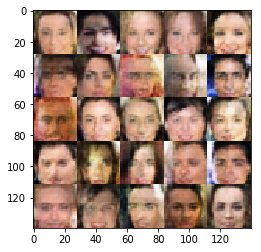

Epoch 2/2: batch 2310: discriminator loss: 1.2340 generator loss: 0.9710
Epoch 2/2: batch 2320: discriminator loss: 1.2793 generator loss: 0.6385
Epoch 2/2: batch 2330: discriminator loss: 1.1751 generator loss: 1.0772
Epoch 2/2: batch 2340: discriminator loss: 1.1490 generator loss: 1.0770
Epoch 2/2: batch 2350: discriminator loss: 1.2980 generator loss: 0.6849
Epoch 2/2: batch 2360: discriminator loss: 1.2995 generator loss: 0.6354
Epoch 2/2: batch 2370: discriminator loss: 1.3244 generator loss: 1.1542
Epoch 2/2: batch 2380: discriminator loss: 1.1562 generator loss: 1.3403
Epoch 2/2: batch 2390: discriminator loss: 1.4016 generator loss: 1.2566
Epoch 2/2: batch 2400: discriminator loss: 1.2910 generator loss: 0.9148


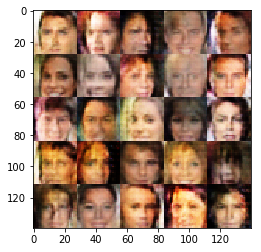

Epoch 2/2: batch 2410: discriminator loss: 1.3667 generator loss: 0.6444
Epoch 2/2: batch 2420: discriminator loss: 1.1945 generator loss: 0.8312
Epoch 2/2: batch 2430: discriminator loss: 1.4594 generator loss: 1.5508
Epoch 2/2: batch 2440: discriminator loss: 1.3168 generator loss: 0.9379
Epoch 2/2: batch 2450: discriminator loss: 1.1351 generator loss: 0.9966
Epoch 2/2: batch 2460: discriminator loss: 1.3092 generator loss: 0.9848
Epoch 2/2: batch 2470: discriminator loss: 1.3217 generator loss: 0.7397
Epoch 2/2: batch 2480: discriminator loss: 1.2318 generator loss: 1.0176
Epoch 2/2: batch 2490: discriminator loss: 1.2373 generator loss: 0.6685
Epoch 2/2: batch 2500: discriminator loss: 1.2067 generator loss: 1.0501


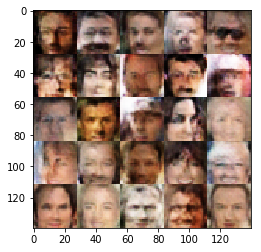

Epoch 2/2: batch 2510: discriminator loss: 1.3731 generator loss: 1.4146
Epoch 2/2: batch 2520: discriminator loss: 1.1353 generator loss: 1.0589
Epoch 2/2: batch 2530: discriminator loss: 1.2641 generator loss: 0.9165
Epoch 2/2: batch 2540: discriminator loss: 1.2064 generator loss: 0.9876
Epoch 2/2: batch 2550: discriminator loss: 1.2969 generator loss: 1.1691
Epoch 2/2: batch 2560: discriminator loss: 1.3212 generator loss: 0.8296
Epoch 2/2: batch 2570: discriminator loss: 1.3185 generator loss: 1.0635
Epoch 2/2: batch 2580: discriminator loss: 1.3017 generator loss: 0.8688
Epoch 2/2: batch 2590: discriminator loss: 1.2409 generator loss: 0.8199
Epoch 2/2: batch 2600: discriminator loss: 1.5995 generator loss: 1.4303


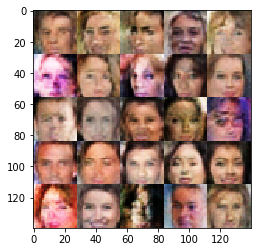

Epoch 2/2: batch 2610: discriminator loss: 1.2189 generator loss: 0.8492
Epoch 2/2: batch 2620: discriminator loss: 1.2330 generator loss: 0.9268
Epoch 2/2: batch 2630: discriminator loss: 1.2255 generator loss: 0.9489
Epoch 2/2: batch 2640: discriminator loss: 1.3586 generator loss: 0.6403
Epoch 2/2: batch 2650: discriminator loss: 1.2552 generator loss: 0.7116
Epoch 2/2: batch 2660: discriminator loss: 1.2507 generator loss: 0.8722
Epoch 2/2: batch 2670: discriminator loss: 1.2596 generator loss: 0.8963
Epoch 2/2: batch 2680: discriminator loss: 1.2808 generator loss: 1.1524
Epoch 2/2: batch 2690: discriminator loss: 1.3951 generator loss: 1.4210
Epoch 2/2: batch 2700: discriminator loss: 1.2421 generator loss: 1.0945


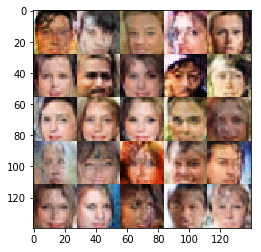

Epoch 2/2: batch 2710: discriminator loss: 1.2780 generator loss: 0.7142
Epoch 2/2: batch 2720: discriminator loss: 1.2688 generator loss: 0.6216
Epoch 2/2: batch 2730: discriminator loss: 1.3507 generator loss: 1.1175
Epoch 2/2: batch 2740: discriminator loss: 1.1409 generator loss: 0.9881
Epoch 2/2: batch 2750: discriminator loss: 1.3807 generator loss: 1.3812
Epoch 2/2: batch 2760: discriminator loss: 1.2677 generator loss: 0.7490
Epoch 2/2: batch 2770: discriminator loss: 1.2610 generator loss: 1.1718
Epoch 2/2: batch 2780: discriminator loss: 1.1945 generator loss: 0.8648
Epoch 2/2: batch 2790: discriminator loss: 1.3792 generator loss: 0.5988
Epoch 2/2: batch 2800: discriminator loss: 1.3556 generator loss: 1.1068


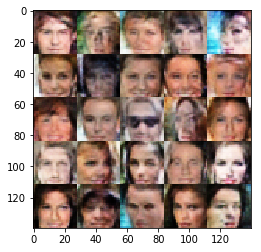

Epoch 2/2: batch 2810: discriminator loss: 1.3390 generator loss: 1.3260
Epoch 2/2: batch 2820: discriminator loss: 1.2894 generator loss: 0.6942
Epoch 2/2: batch 2830: discriminator loss: 1.3673 generator loss: 0.7290
Epoch 2/2: batch 2840: discriminator loss: 1.2386 generator loss: 0.7560
Epoch 2/2: batch 2850: discriminator loss: 1.2192 generator loss: 0.7691
Epoch 2/2: batch 2860: discriminator loss: 1.2669 generator loss: 0.8519
Epoch 2/2: batch 2870: discriminator loss: 1.2822 generator loss: 0.7383
Epoch 2/2: batch 2880: discriminator loss: 1.2435 generator loss: 0.8061
Epoch 2/2: batch 2890: discriminator loss: 1.4360 generator loss: 1.1431
Epoch 2/2: batch 2900: discriminator loss: 1.2810 generator loss: 0.8635


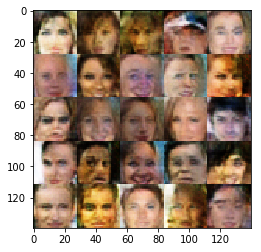

Epoch 2/2: batch 2910: discriminator loss: 1.3073 generator loss: 0.9640
Epoch 2/2: batch 2920: discriminator loss: 1.2902 generator loss: 0.9262
Epoch 2/2: batch 2930: discriminator loss: 1.3277 generator loss: 1.2586
Epoch 2/2: batch 2940: discriminator loss: 1.1722 generator loss: 1.0249
Epoch 2/2: batch 2950: discriminator loss: 1.3529 generator loss: 0.6644
Epoch 2/2: batch 2960: discriminator loss: 1.2669 generator loss: 0.8668
Epoch 2/2: batch 2970: discriminator loss: 1.2683 generator loss: 0.6794
Epoch 2/2: batch 2980: discriminator loss: 1.3874 generator loss: 0.5477
Epoch 2/2: batch 2990: discriminator loss: 1.1954 generator loss: 0.9821
Epoch 2/2: batch 3000: discriminator loss: 1.2083 generator loss: 0.8082


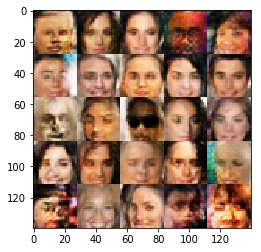

Epoch 2/2: batch 3010: discriminator loss: 1.2807 generator loss: 0.7477
Epoch 2/2: batch 3020: discriminator loss: 1.2955 generator loss: 0.6163
Epoch 2/2: batch 3030: discriminator loss: 1.4319 generator loss: 0.5096
Epoch 2/2: batch 3040: discriminator loss: 1.2599 generator loss: 0.7610
Epoch 2/2: batch 3050: discriminator loss: 1.2363 generator loss: 0.8634
Epoch 2/2: batch 3060: discriminator loss: 1.2617 generator loss: 0.8191
Epoch 2/2: batch 3070: discriminator loss: 1.3457 generator loss: 0.6228
Epoch 2/2: batch 3080: discriminator loss: 1.3120 generator loss: 0.8349
Epoch 2/2: batch 3090: discriminator loss: 1.2164 generator loss: 0.9132
Epoch 2/2: batch 3100: discriminator loss: 1.2449 generator loss: 1.2123


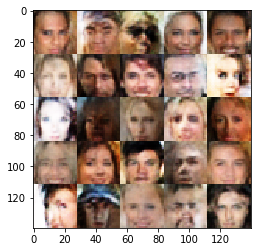

Epoch 2/2: batch 3110: discriminator loss: 1.3121 generator loss: 0.6481
Epoch 2/2: batch 3120: discriminator loss: 1.2734 generator loss: 1.4010
Epoch 2/2: batch 3130: discriminator loss: 1.1758 generator loss: 0.8497
Epoch 2/2: batch 3140: discriminator loss: 1.4349 generator loss: 0.4746
Epoch 2/2: batch 3150: discriminator loss: 1.2472 generator loss: 0.7845
Epoch 2/2: batch 3160: discriminator loss: 1.4072 generator loss: 1.1198


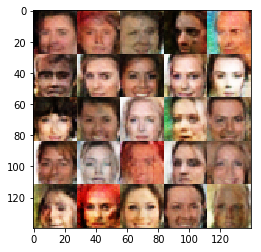

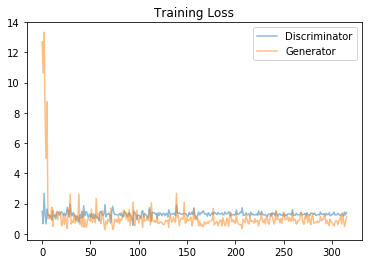

In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3

d_losses = []
g_losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
    
    plot_losses(d_losses, g_losses)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.